In [1]:
import numpy as np
import pandas as pd
import subprocess
import os
import shutil
import warnings
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

exp ='spaceloc'
subj_list=["docnet1001", "docnet1002"] #subs to analyze
suf = ["_odd", "_even", "_all"] #runs to pull ROIs from
rois=["V3ab", "PPC", "APC", "LO", "PFS"] #Rois
loc_cope=[1, 1, 1, 2, 2] #copes for localizer runs; corresponding numerically to each roi
exp_cope=[8, 9, 10, 11] #experimental copes to test in each ROI
cond=["SA", "FT", "SS", "SF"]
cond_name =  ["Space", "Feature", "Scrambled_Space", "Scrambled_Feature"]

data_dir = "/lab_data/behrmannlab/vlad/docnet"

Extract functional localizer data from each ROI

Extract parameter estimate from each mask

In [86]:
for ss in subj_list:
    sub_dir = f"{data_dir}/sub-{ss}/ses-01/derivatives"
    results_dir = f'{sub_dir}/beta/selectivity'
       
    if os.path.exists(results_dir):
        shutil.rmtree(results_dir)
    
    os.makedirs(results_dir) 
    
    for sf_loc in suf: #loop across run type for the masks
        for rr in range(0,len(rois)): #loop across rois
            for lr in ['l','r']: #loop across left and right hemispheres
                #check if ROI exists
                roi_nifti = f'{sub_dir}/rois/{lr}{rois[rr]}{sf_loc}.nii.gz'
                if os.path.exists(roi_nifti):
                    
                    #Extract functional z-stat data from the localizer
                    #if sf_loc != '_all':
                    loc_suf = f'{sf_loc}_smooth'
                    #else:
                    #   loc_suf = sf_loc
                        
                    cope_nifti = f"{sub_dir}/fsl/{exp}/HighLevel{loc_suf}.gfeat/cope{loc_cope[rr]}.feat/stats/zstat1.nii.gz"
                    out = f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer'
                    #extract_data(cope_nifti, roi_nifti, f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer')
                    
                    bash_cmd  = f'fslmeants -i {cope_nifti} -m {roi_nifti} -o {out}.txt --showall --transpose'
                    subprocess.run(bash_cmd.split(),check=True)

                    for sf_exp in suf: #loop across the run types for the copes
                        exp_suf = f'{sf_exp}_unsmoothed'
                        if sf_exp != "_all": #we don't test data for all
                            for ec in range(0,len(exp_cope)):
                                cope_nifti = f"{sub_dir}/fsl/{exp}/HighLevel{exp_suf}.gfeat/cope{exp_cope[ec]}.feat/stats/zstat1.nii.gz"
                                out = f'{results_dir}/{lr}{rois[rr]}{sf_loc}{sf_exp}_{cond[ec]}'
                                #extract_data(roi_nifti, cope_nifti, f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer.nii.gz')

                                bash_cmd  = f'fslmeants -i {cope_nifti} -m {roi_nifti} -o {out}.txt --showall --transpose'
                                #print(bash_cmd)
                                subprocess.run(bash_cmd.split(),check=True)


Load localizer and test data, append, average together, and plot

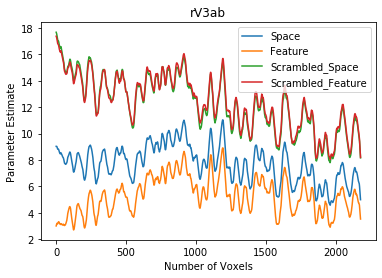

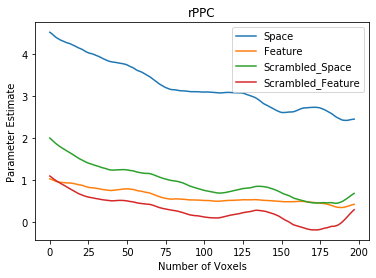

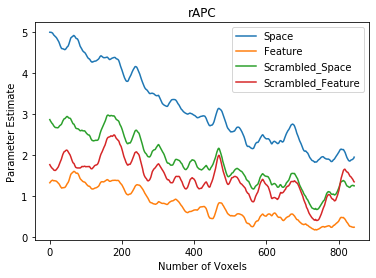

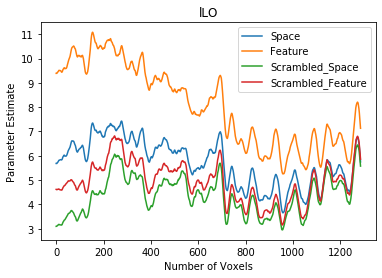

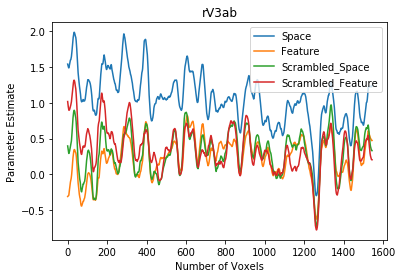

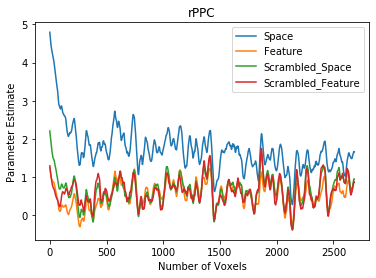

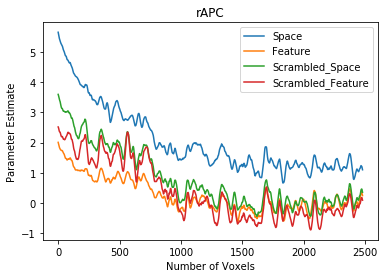

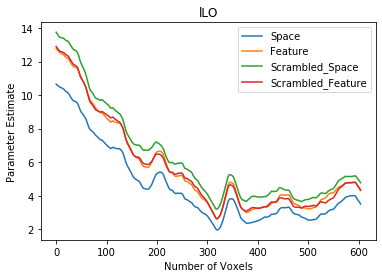

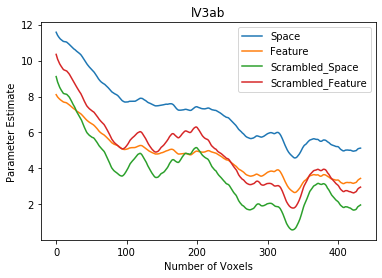

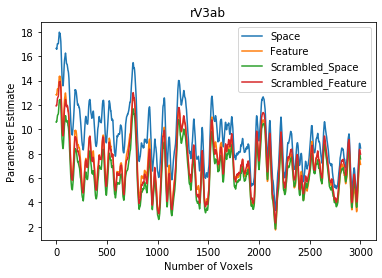

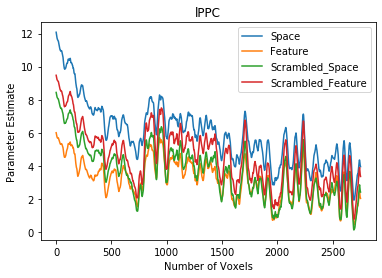

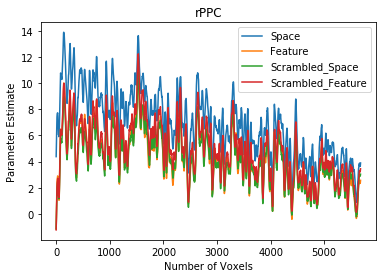

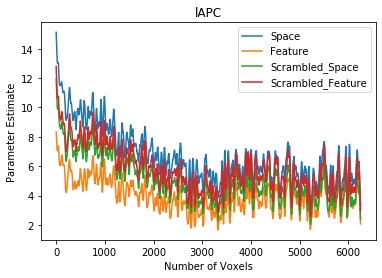

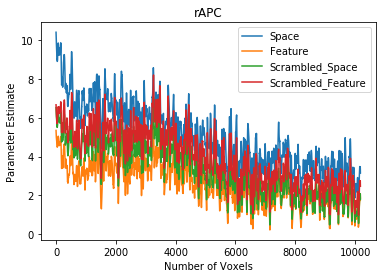

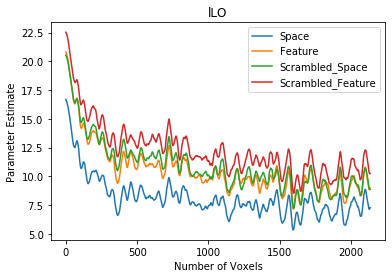

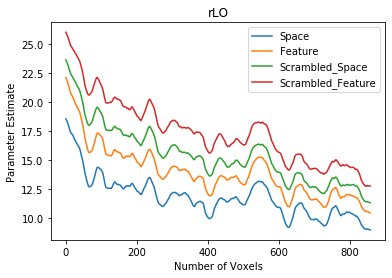

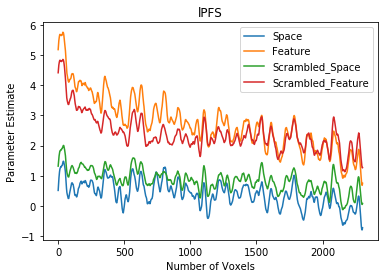

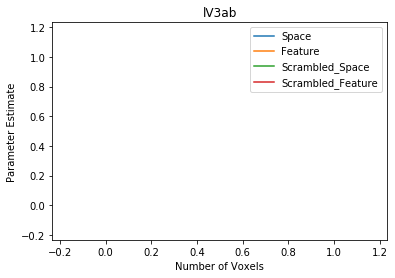

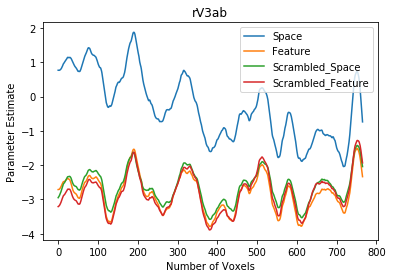

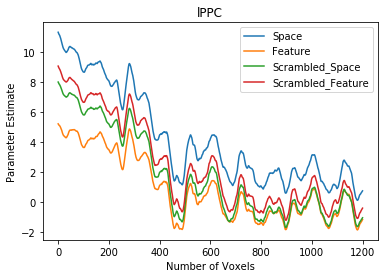

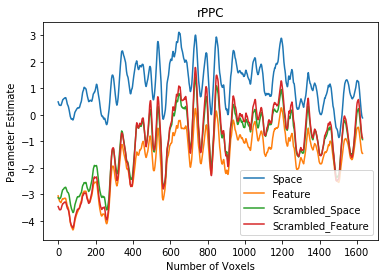

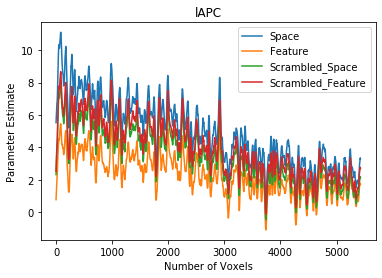

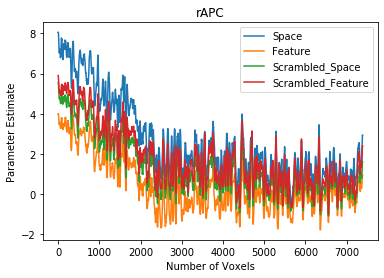

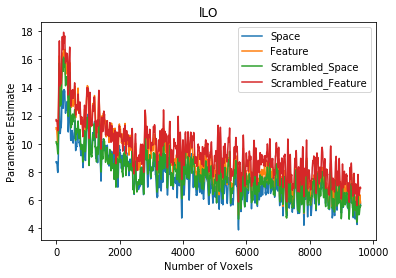

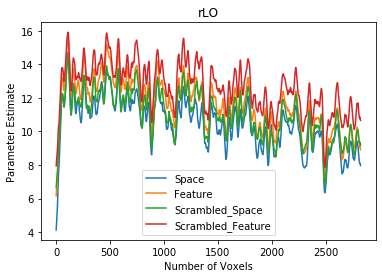

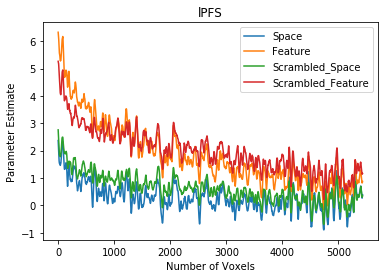

In [97]:
for ss in subj_list:
    sub_dir = f"{data_dir}/sub-{ss}/ses-01/derivatives"
    results_dir = f'{sub_dir}/beta/selectivity'
    
    for sf_loc in suf: #loop across run type for the masks
        for rr in range(0,len(rois)): #loop across rois
            for lr in ['l','r']: #loop across left and right hemispheres

                odd_file = f'{results_dir}/{lr}{rois[rr]}_odd_localizer.txt'
                even_file = f'{results_dir}/{lr}{rois[rr]}_even_localizer.txt'
                #temporarily not running ALL
                if os.path.exists(odd_file) and os.path.exists(even_file) or sf_loc == "_all": 
                    loc_file = f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer.txt'
                    loc_df = pd.read_csv(loc_file, sep="  ", header=None)
                    loc_df.columns = ["x", "y", "z", "loc"]

                    if sf_loc != "_all": #If localizer from odd/even runs
                        #pull data from opposite runs
                        if sf_loc == "_even": 
                            sf_exp="_odd"
                        else:
                            sf_exp =="_even"

                        for cc in cond:
                            exp_file = f'{results_dir}/{lr}{rois[rr]}{sf_loc}{sf_exp}_{cc}.txt'
                            if os.path.exists(exp_file):
                                exp_df = pd.read_csv(exp_file, sep="  ", header=None)
                                exp_df.columns = ["x", "y", "z", cc]
                                loc_df = loc_df.join(exp_df[cc])
                                

                        loc_df = loc_df.sort_values(by =['loc'], ascending=False)


                        df = loc_df.rolling(bin_size, win_type='triang').mean()
                        df = df.dropna()
                        

                        df_plot = df[['SA', 'FT', 'SS','SF']]
                        df_plot= df_plot.reset_index(drop=True)
                        df_plot.columns = ["Space", "Feature", "Scrambled_Space", "Scrambled_Feature"]
                        ax = df_plot.plot.line()
                        ax.set_xlabel("Number of Voxels")
                        ax.set_ylabel("Parameter Estimate")
                        plt.title(f'{lr}{rois[rr]}')
                        plt.savefig(f'{sub_dir}/results/{lr}{rois[rr]}.png')


In [91]:
print(loc_file)
print()

/lab_data/behrmannlab/vlad/docnet/sub-docnet1002/ses-01/derivatives/beta/selectivity/lPFS_all_localizer.txt


In [88]:
print(odd_file, even_file)

/lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/beta/selectivity/rV3ab_odd_localizer.txt /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/beta/selectivity/rV3ab_even_localizer.txt


In [79]:
rois[rr]

'APC'

Text(0.5, 1.0, 'APC')

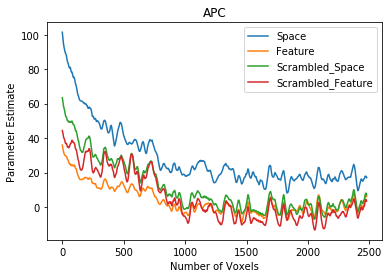

In [82]:
bin_size = 50
df = loc_df.rolling(bin_size, win_type='triang').mean()
df = df.dropna()
ind = pd.DataFrame({'ind':list(range(0,len(df)))})

df_plot = df[['SA', 'FT', 'SS','SF']]
df_plot= df_plot.reset_index(drop=True)
df_plot.columns = ["Space", "Feature", "Scrambled_Space", "Scrambled_Feature"]
ax = df_plot.plot.line()
ax.set_xlabel("Number of Voxels")
ax.set_ylabel("Parameter Estimate")
plt.title(rois[rr])


In [62]:
ind = pd.DataFrame({'ind':list(range(0,len(df)))})
print(ind)

       ind
0        0
1        1
2        2
3        3
4        4
...    ...
2474  2474
2475  2475
2476  2476
2477  2477
2478  2478

[2479 rows x 1 columns]


In [33]:
cc ="SA"
exp_file = f'{results_dir}/{lr}{rois[rr]}{exp_suf}_{cc}.txt'
test = pd.read_csv(exp_file, sep="  ", header=None)
exp_df.columns = ["x", "y", "z", cc]
print(cc)

SA


In [43]:
for ss in subj_list:
    sub_dir = f"{data_dir}/sub-{ss}/ses-01/derivatives"
    results_dir = f'{sub_dir}/beta/selectivity'
    
    for sf_loc in suf: #loop across run type for the masks
        for rr in range(0,len(rois)): #loop across rois
            for lr in ['l','r']: #loop across left and right hemispheres
                loc_df = f'{results_dir}/{lr}{rois[rr]}{sf_loc}_localizer.txt'
                
                if os.path.exists(roi_nifti):
                    df = pd.read_csv(loc_df, sep=" ", header=None)
                    
                                 
    
    

fslmeants -i /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/fsl/spaceloc/HighLevel_all_unsmoothed.gfeat/cope8.feat/stats/pe1.nii.gz -m /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/rois/rV3ab_odd.nii.gz -o /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/beta/selectivity/rV3ab_odd_SA.txt --showall --transpose


In [32]:
ec = 0
f'{results_dir}/{lr}{rois[rr]}{sf_loc}_{cond[ec]}'

'/lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/beta/selectivity/rV3ab_odd_SA'

In [ ]:
fslmeants -i /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/fsl/spaceloc/HighLevel_odd_unsmooth.gfeat/cope8.feat/stats/pe1.nii.gz -m /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/rois/rV3ab_odd.nii.gz -o /lab_data/behrmannlab/vlad/docnet/sub-docnet1001/ses-01/derivatives/beta/selectivity/rV3ab_odd_SA.txt --showall --transpose